In [1]:
from collections import Counter
import os

from huggingface_hub import login
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import regex as re
from transformers import BertTokenizer, XLMRobertaTokenizerFast
from tqdm import tqdm

/home/wolfingten/.python_environments/ML/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
# authentication with huggingface
# !pip install ipywidgets
# request data access at https://huggingface.co/datasets/Cofacts/line-msg-fact-check-tw
# create token at https://huggingface.co/settings/tokens (create as read)
# token should be stored locally, so technically login is only needed one time
login()

In [3]:
# download specific dataset files; entire archive is only ~250 mb
articles = load_dataset("Cofacts/line-msg-fact-check-tw", "articles") # article contents and some meta info
article_replies = load_dataset("Cofacts/line-msg-fact-check-tw", "article_replies") # 'join table' for articles and replies with added meta info

In [115]:
art_rep_df = pd.merge(articles["train"].to_pandas(), article_replies["train"].to_pandas(), left_on="id", right_on="articleId", how="left")
art_rep_df.head()
# replyType is the label assigned to the article by the human editor

,id,articleType,status_x,text,normalArticleReplyCount,createdAt_x,updatedAt_x,lastRequestedAt,userIdsha256_x,appId_x,...,articleId,replyId,userIdsha256_y,negativeFeedbackCount,positiveFeedbackCount,replyType,appId_y,status_y,createdAt_y,updatedAt_y
0,14h550ymn3m3u,TEXT,NORMAL,BA.5病毒引發的不只「縮短潛伏期，增加R0值」，還有易使人「再感染（Reinfecion）...,1.0,2022-09-05T05:26:33.360Z,2022-09-05T05:26:33.360Z,2022-09-05T05:26:33.381Z,3753ca22ca96f5fc1f13e62291f28e405d56b1a976b21d...,RUMORS_LINE_BOT,...,14h550ymn3m3u,6oo8DYMBv5it-Cx_8405,6892d0026181e95d034bf8781025afbf395d57cc88ac05...,0.0,3.0,RUMOR,WEBSITE,NORMAL,2022-09-05T10:40:41.789Z,2022-09-05T10:40:41.789Z
1,326xjpkjbf01i,TEXT,NORMAL,https://youtu.be/xK9NzL3PkdE,0.0,2022-09-08T12:34:27.602Z,2022-09-08T12:34:27.602Z,2022-09-08T12:34:27.634Z,243b5897c14f02fb5b92a9e4f4cc39d5fb84ff16173add...,RUMORS_LINE_BOT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,oupi0eu9aocr,TEXT,NORMAL,被取消的航班\n\n2018年的一天，我從洛杉磯回國，乘坐凌晨一點的國航航班，馬上要登機了，...,1.0,2021-11-13T16:36:56.548Z,2021-11-13T16:36:56.548Z,2022-04-27T08:52:17.115Z,4a266a6fdefc88e59eef644402e97c7f4c8196becca686...,RUMORS_LINE_BOT,...,oupi0eu9aocr,MYotCYMBv5it-Cx_gIpH,fc9652aa205dab75e19ecff420945e95aa3909a54b0d9a...,0.0,1.0,OPINIONATED,WEBSITE,NORMAL,2022-09-04T15:45:20.464Z,2022-09-04T15:45:20.464Z
3,my5ep5z69tql,TEXT,NORMAL,你好👱🏻‍♀️\n\n簡單跟你說一下公司工作內容：\n我們是做購物系統訂單的工作，主要就是增...,1.0,2022-08-11T20:53:15.644Z,2022-08-11T20:53:15.644Z,2022-09-07T11:02:00.344Z,8a8a319bea0b3bff580d8507ae6470ba37e87791171886...,RUMORS_LINE_BOT,...,my5ep5z69tql,y22DlmsBFV14knB4ErTJ,d16417c7ce4ab67ac5a7901ce62621445db3e06da5da6f...,0.0,1.0,RUMOR,WEBSITE,NORMAL,2022-09-07T22:59:48.921Z,2022-09-07T22:59:48.921Z
4,3dnh713ikpf3c,TEXT,NORMAL,先和你簡單介紹\n我們誠徵線上打工小幫手\n工作內容有：聽寫打字、頁面排版、商品評論刷流量、...,1.0,2022-09-07T10:10:41.742Z,2022-09-07T10:10:41.742Z,2022-09-07T10:10:41.761Z,47e90b2538a5615b323f50571b77d91f7f105e55684aa1...,RUMORS_LINE_BOT,...,3dnh713ikpf3c,H8Hz4WsBqwaEkHKwtyFm,d16417c7ce4ab67ac5a7901ce62621445db3e06da5da6f...,0.0,1.0,RUMOR,WEBSITE,NORMAL,2022-09-07T23:00:19.207Z,2022-09-07T23:00:19.207Z


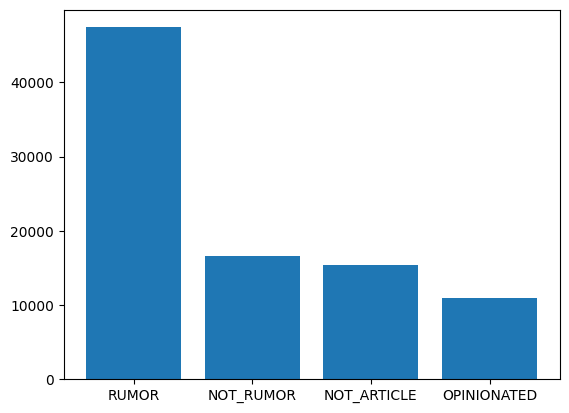

replyType
RUMOR          47408
NOT_RUMOR      16613
NOT_ARTICLE    15430
OPINIONATED    10955
Name: count, dtype: int64


In [5]:
# imbalance
cat_counts = art_rep_df["replyType"].value_counts()
plt.bar(cat_counts.index, cat_counts.values)
plt.show()
print(cat_counts)

In [6]:
def get_max_length(texts: list):
    max_length = 0
    for t in texts:
        if t:
            max_length = max(max_length, len(t))
    return max_length

def inspect_dist(col: list, threshold = 0):
    if threshold == 0:
        plt.hist(col, bins=100)
        plt.show()
    else:
        plt.hist(col[col <= threshold], bins=100)
        plt.show()
        print(f"Remaining datapoints: {len(col[col <= threshold]) / len(col)}")

In [7]:
get_max_length(art_rep_df["text"])

10037

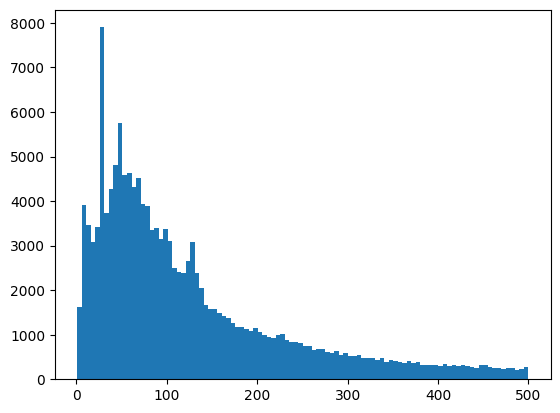

Remaining datapoints: 0.878993991129763


In [8]:
inspect_dist(art_rep_df["text"].dropna().apply(len), threshold=500)

In [9]:
art_rep_df[art_rep_df["text"].str.len() == 28]
# NOTE: remove urls

,id,articleType,status_x,text,normalArticleReplyCount,createdAt_x,updatedAt_x,lastRequestedAt,userIdsha256_x,appId_x,...,articleId,replyId,userIdsha256_y,negativeFeedbackCount,positiveFeedbackCount,replyType,appId_y,status_y,createdAt_y,updatedAt_y
1,326xjpkjbf01i,TEXT,NORMAL,https://youtu.be/xK9NzL3PkdE,0.0,2022-09-08T12:34:27.602Z,2022-09-08T12:34:27.602Z,2022-09-08T12:34:27.634Z,243b5897c14f02fb5b92a9e4f4cc39d5fb84ff16173add...,RUMORS_LINE_BOT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,2ihx6b0hy6reh,TEXT,NORMAL,https://fb.watch/fqyCukx77O/,0.0,2022-09-09T08:30:45.294Z,2022-09-09T08:30:45.294Z,2022-09-09T08:30:45.321Z,67cb002cbd4884b64f03aca3400e67a867b35e3838caa3...,RUMORS_LINE_BOT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115,2zvytlna89voa,TEXT,NORMAL,https://youtu.be/EHvxmzP7Mfw,0.0,2022-09-11T00:24:14.167Z,2022-09-11T00:24:14.167Z,2022-09-11T00:24:14.197Z,1b8841d66c76e5ebbce83a71ddfa61fea29c32a736218f...,RUMORS_LINE_BOT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132,32745wxu27y2q,TEXT,NORMAL,https://youtu.be/BSh2Lj_OrDs,0.0,2022-09-11T06:24:59.763Z,2022-09-11T06:24:59.763Z,2022-09-11T06:24:59.791Z,9fdd5c5952dbbe145c4f00ca018fe0979e5875fbac45fe...,RUMORS_LINE_BOT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
160,1ppbai7d2l96o,TEXT,NORMAL,https://youtu.be/3nX_ctdukOI,0.0,2022-09-11T12:29:43.754Z,2022-09-11T12:29:43.754Z,2022-09-11T12:29:43.786Z,5e19fe6083cf02075ff2e022e526a4b09d4958780174d3...,RUMORS_LINE_BOT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168960,h9io4zcc5wbg,TEXT,NORMAL,了解 先自我介紹一下 我是淞瑋包裝材料行徵工代表：葉佳倩,1.0,2024-01-20T06:44:26.971Z,2024-01-20T06:44:26.971Z,2024-01-25T08:35:51.328Z,17295e1f0761fd28c74ff00632d2dd29dbf37baf42f8f0...,RUMORS_LINE_BOT,...,h9io4zcc5wbg,qPc9Qo0BAjOeMOklzqEu,7708d900e0a9d4a92ad69381b1e0782338787e027954ce...,0.0,0.0,RUMOR,WEBSITE,NORMAL,2024-01-25T20:09:23.249Z,2024-01-25T20:09:23.249Z
169040,3dl8g74u3exnz,TEXT,NORMAL,要去app sotre搜尋COINCENTEL載到桌布喔,0.0,2024-01-26T12:11:53.760Z,2024-01-26T12:11:53.760Z,2024-01-26T12:11:53.777Z,8ab6707dd0821b0605969c1bc0481d3ca0bbc87953c9ee...,RUMORS_LINE_BOT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
169313,22vlxdwzs7l7d,TEXT,NORMAL,https://txp.rs/v/ACr5NfeCEn2,0.0,2024-01-26T06:04:22.281Z,2024-01-26T06:04:22.281Z,2024-01-26T06:04:22.293Z,63318d9d6b88b75fac18d8bdb41a5b38ffa759576210f3...,RUMORS_LINE_BOT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
169315,ok8jtnk1pj9g,TEXT,NORMAL,https://youtu.be/UwtXzwckeWQ,0.0,2023-05-18T04:27:21.707Z,2023-05-18T04:27:21.707Z,2024-01-26T07:19:52.516Z,e87d917e34b761d233273ebd5cf339be6c92c0920ceafc...,RUMORS_LINE_BOT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [127]:
# https://symbl.cc/en/unicode/blocks/

# retain
# chinese block: \u4E00-\u9FFF
# cjk punctuation: \u3000-\u303F
# ascii block: \u0000-\u007F
# general punctuation: \u2000-\u206F
# halfwidth punctuation: \uFF00-\uFF65

# preserve other scripts? (japanese, korean, thai, ...)
# presentation form punctuation: \uFE00-\uFFFF
# mathematical operators: \u2200-\u22FF

# discard
# \u1F000-\u1FBFF
# dingdats: \u2700-\u27BF
# emojis: \u1F600-\u1F64F

In [150]:
### Preprocessing so far

def remove_url(text: str):
    regex = r"https?\S+|\S*\.com\S*"
    text = re.sub("\n", " ", text) # also remove newlines. Beware trailing whitespaces
    text = re.sub(regex, "", text)
    if len(text) == 0:
        text = pd.NA
    return text

def filter_unicodes(texts: list):
    retain = list()
    remove = list()
    for t in texts:
        if pd.notna(t):
            regex = re.compile(r"[^\u4E00-\u9FFF\u3000-\u303F\u0000-\u007F\u2000-\u206F\uFF00-\uFF65]")
            filtered_txt = regex.sub("", t)
            retain.append(filtered_txt)
            deleted = regex.findall(t)
            remove.append(deleted)
        else:
            retain.append(t)
    remove = Counter([i for l in remove for i in l])
    return retain, remove

def find_unicodes(chars: list):
    out = {char : char.encode("unicode_escape") for char in chars}
    return out

# processing steps
clean_df = art_rep_df.copy()
clean_df = clean_df[clean_df["replyType"] != "NOT_ARTICLE"] # remove non articles
clean_df = clean_df.dropna(subset=["text", "replyType"]) # drop na's
clean_df["text"] = clean_df["text"].apply(remove_url) # delete urls
clean_df["text"], remove = filter_unicodes(clean_df["text"]) # filter for chinese and latin script
clean_df = clean_df.dropna(subset=["text", "replyType"])
clean_df.head()
# still some user ids, urls with uncommon domains

,id,articleType,status_x,text,normalArticleReplyCount,createdAt_x,updatedAt_x,lastRequestedAt,userIdsha256_x,appId_x,...,articleId,replyId,userIdsha256_y,negativeFeedbackCount,positiveFeedbackCount,replyType,appId_y,status_y,createdAt_y,updatedAt_y
0,14h550ymn3m3u,TEXT,NORMAL,BA.5病毒引發的不只「縮短潛伏期，增加R0值」，還有易使人「再感染（Reinfecion）...,1.0,2022-09-05T05:26:33.360Z,2022-09-05T05:26:33.360Z,2022-09-05T05:26:33.381Z,3753ca22ca96f5fc1f13e62291f28e405d56b1a976b21d...,RUMORS_LINE_BOT,...,14h550ymn3m3u,6oo8DYMBv5it-Cx_8405,6892d0026181e95d034bf8781025afbf395d57cc88ac05...,0.0,3.0,RUMOR,WEBSITE,NORMAL,2022-09-05T10:40:41.789Z,2022-09-05T10:40:41.789Z
2,oupi0eu9aocr,TEXT,NORMAL,被取消的航班 2018年的一天，我從洛杉磯回國，乘坐凌晨一點的國航航班，馬上要登機了，我站...,1.0,2021-11-13T16:36:56.548Z,2021-11-13T16:36:56.548Z,2022-04-27T08:52:17.115Z,4a266a6fdefc88e59eef644402e97c7f4c8196becca686...,RUMORS_LINE_BOT,...,oupi0eu9aocr,MYotCYMBv5it-Cx_gIpH,fc9652aa205dab75e19ecff420945e95aa3909a54b0d9a...,0.0,1.0,OPINIONATED,WEBSITE,NORMAL,2022-09-04T15:45:20.464Z,2022-09-04T15:45:20.464Z
3,my5ep5z69tql,TEXT,NORMAL,你好‍ 簡單跟你說一下公司工作內容： 我們是做購物系統訂單的工作，主要就是增加產品購買交易...,1.0,2022-08-11T20:53:15.644Z,2022-08-11T20:53:15.644Z,2022-09-07T11:02:00.344Z,8a8a319bea0b3bff580d8507ae6470ba37e87791171886...,RUMORS_LINE_BOT,...,my5ep5z69tql,y22DlmsBFV14knB4ErTJ,d16417c7ce4ab67ac5a7901ce62621445db3e06da5da6f...,0.0,1.0,RUMOR,WEBSITE,NORMAL,2022-09-07T22:59:48.921Z,2022-09-07T22:59:48.921Z
4,3dnh713ikpf3c,TEXT,NORMAL,先和你簡單介紹 我們誠徵線上打工小幫手 工作內容有：聽寫打字、頁面排版、商品評論刷流量、按讚...,1.0,2022-09-07T10:10:41.742Z,2022-09-07T10:10:41.742Z,2022-09-07T10:10:41.761Z,47e90b2538a5615b323f50571b77d91f7f105e55684aa1...,RUMORS_LINE_BOT,...,3dnh713ikpf3c,H8Hz4WsBqwaEkHKwtyFm,d16417c7ce4ab67ac5a7901ce62621445db3e06da5da6f...,0.0,1.0,RUMOR,WEBSITE,NORMAL,2022-09-07T23:00:19.207Z,2022-09-07T23:00:19.207Z
5,2m9drd702d8l1,TEXT,NORMAL,【樂天貸款】尊敬的用戶，您的借款額度已提升到50萬，當天領取當天到賬，及時添加專員提現LIN...,1.0,2022-09-07T11:56:37.690Z,2022-09-07T11:56:37.690Z,2022-09-07T11:56:37.713Z,c8d02860e8fdeea921585710dba8e3eb8da914b57f3ad4...,RUMORS_LINE_BOT,...,2m9drd702d8l1,moopGoMBv5it-Cx_FZnG,d16417c7ce4ab67ac5a7901ce62621445db3e06da5da6f...,0.0,1.0,RUMOR,WEBSITE,NORMAL,2022-09-07T22:54:03.723Z,2022-09-07T22:54:03.723Z


In [145]:
find_unicodes([c[0] for c in remove.most_common()])

{'\xa0': b'\\xa0',
 '﹔': b'\\ufe54',
 '️': b'\\ufe0f',
 '⋯': b'\\u22ef',
 '﹐': b'\\ufe50',
 '·': b'\\xb7',
 '↓': b'\\u2193',
 '👇': b'\\U0001f447',
 'о': b'\\u043e',
 '→': b'\\u2192',
 '👉': b'\\U0001f449',
 '●': b'\\u25cf',
 '⚠': b'\\u26a0',
 '۔': b'\\u06d4',
 '🙏': b'\\U0001f64f',
 'а': b'\\u0430',
 'ㄧ': b'\\u3127',
 'т': b'\\u0442',
 'е': b'\\u0435',
 '⃣': b'\\u20e3',
 'с': b'\\u0441',
 'ོ': b'\\u0f7c',
 'и': b'\\u0438',
 '\ufeff': b'\\ufeff',
 '─': b'\\u2500',
 '✅': b'\\u2705',
 '༵': b'\\u0f35',
 '│': b'\\u2502',
 '❤': b'\\u2764',
 '￼': b'\\ufffc',
 'н': b'\\u043d',
 'ل': b'\\u0644',
 '★': b'\\u2605',
 '▼': b'\\u25bc',
 '❗': b'\\u2757',
 'ا': b'\\u0627',
 '🎉': b'\\U0001f389',
 '◎': b'\\u25ce',
 '👍': b'\\U0001f44d',
 'р': b'\\u0440',
 '🔴': b'\\U0001f534',
 'в': b'\\u0432',
 '😱': b'\\U0001f631',
 '🔥': b'\\U0001f525',
 '■': b'\\u25a0',
 'у': b'\\u0443',
 'ﻻ': b'\\ufefb',
 '°': b'\\xb0',
 'い': b'\\u3044',
 '🏻': b'\\U0001f3fb',
 '🌹': b'\\U0001f339',
 '○': b'\\u25cb',
 '⭕': b'\\u2b55',
 'の'